In [21]:
adc_filename = "raw_data_2023-04-01-16-09-25.bin" # 设置想解析的原始数据文件名
frame_index = 10  # 设置想解析的帧的序号

# 解析LVDS接收的ADC原始IQ数据

## 利用numpy对LVDS接收的ADC原始IQ数据进行解析

### 载入相关库

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 设置对应参数

In [4]:
# 可根据cfg文件自己填写（运行采集程序时终端也会打印）
# ADC_PARAMS={'chirps': 128, 'rx': 4, 'tx': 3, 'samples': 256, 'IQ': 2, 'bytes': 2, 'startFreq': 76, 'idleTime': 7.0, 'adc_valid_start_time': 4.0, 'rampEndTime': 15.53, 'freq_slope': 265, 'txStartTime': 1.0, 'sample_rate': 22500, 'frame_periodicity': 8.952}

# 也可从cfg文件自动读取参数
from mmwave.dataloader import DCA1000
_,_,ADC_PARAMS,_=DCA1000.AWR2243_read_config("configFiles/AWR2243_mmwaveconfig.txt")
print(ADC_PARAMS)

{'chirps': 128, 'rx': 4, 'tx': 3, 'samples': 256, 'IQ': 2, 'bytes': 2, 'startFreq': 76.00000002980232, 'idleTime': 7.0, 'adc_valid_start_time': 4.0, 'rampEndTime': 15.53, 'freq_slope': 265.0076150894165, 'txStartTime': 1.0, 'sample_rate': 22500, 'frame_periodicity': 8.952}


### 载入保存的bin数据并解析

In [27]:
adc_data = np.fromfile(adc_filename, dtype=np.int16)

adc_data=np.reshape(adc_data,(-1,ADC_PARAMS['chirps'],ADC_PARAMS['tx'],ADC_PARAMS['samples'],ADC_PARAMS['IQ'],ADC_PARAMS['rx']))
adc_data=np.flip(adc_data,axis=3)#对sample轴取倒序
#100Frames*128Chirps*3TX*256Samples*2IQ*4RX(Lanes)
print(adc_data.shape)

adc_data=np.transpose(adc_data,(0,1,2,5,3,4))
#100Frames*128Chirps*3TX*4RX(Lanes)*256Samples*2IQ
print(adc_data.shape)

adc_data = (1j * adc_data[...,0] + adc_data[...,1]).astype(np.complex64)
#100Frames*128Chirps*3TX*4RX*256Samples复数形式
print(adc_data.shape)

adc_data_2d = np.reshape(adc_data[:,:,0:2,:,:],(-1,ADC_PARAMS['chirps'],2*4,ADC_PARAMS['samples']))
#100Frames*128Chirps*8VirtualAnts*256Samples复数形式
print(adc_data_2d.shape)

(100, 128, 3, 256, 2, 4)
(100, 128, 3, 4, 256, 2)
(100, 128, 3, 4, 256)
(100, 128, 8, 256)


### 绘制时域IQ波形

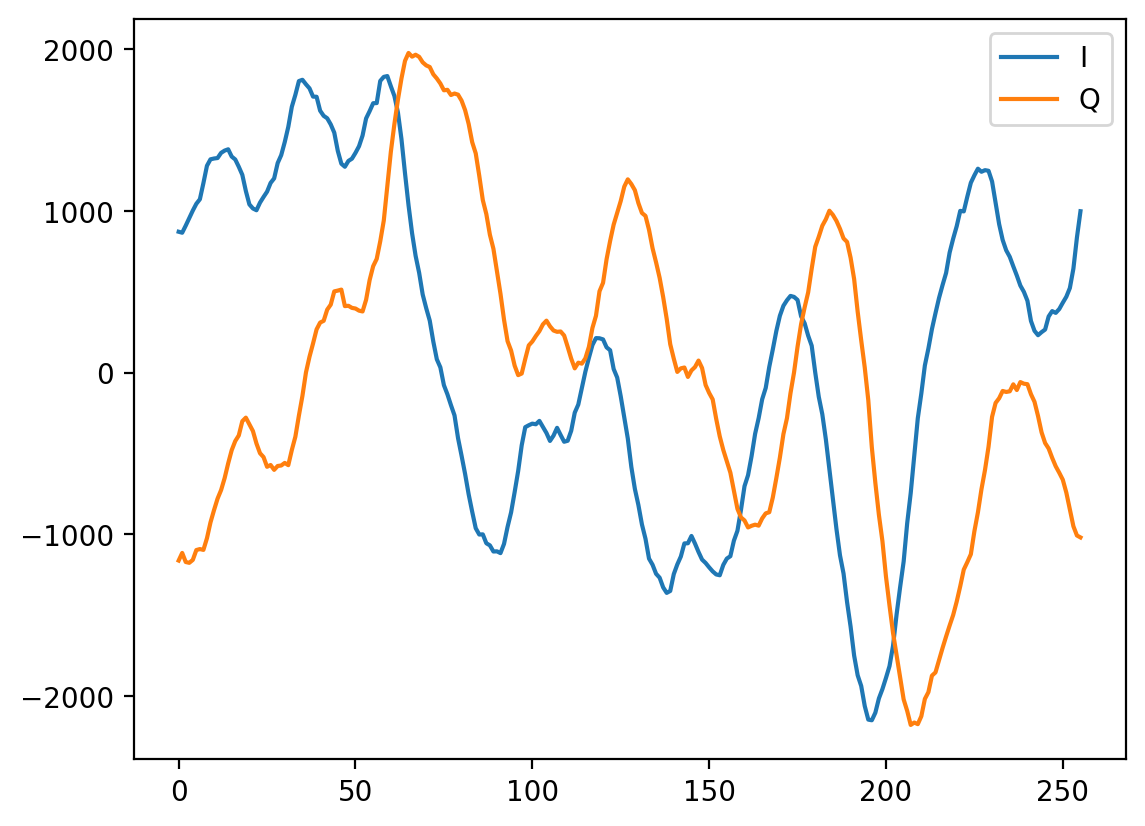

In [29]:
plt.plot(np.real(adc_data[frame_index,0,0,0,:]),label="I") # I路
plt.plot(np.imag(adc_data[frame_index,0,0,0,:]),label="Q") # Q路
plt.legend()
plt.show()

### 计算Range-FFT

Range Resolution: 0.04974798081010506 [meters]


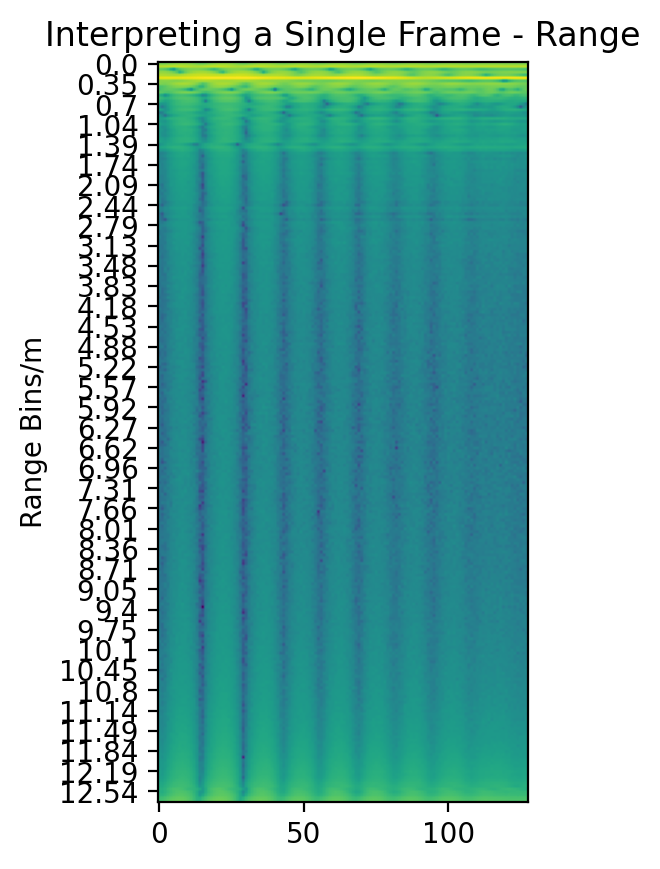

In [30]:
range_plot = np.fft.fft(adc_data_2d[frame_index], axis=2)
# Calculating bandwidth of the chirp, accounting for unit conversion
chirp_bandwidth = (ADC_PARAMS['freq_slope'] * 1e12 * ADC_PARAMS['samples']) / (ADC_PARAMS['sample_rate'] * 1e3)

# Using our derived equation for range resolution
range_res = 3e8 / (2 * chirp_bandwidth)
print(f'Range Resolution: {range_res} [meters]')

# Apply the range resolution factor to the range indices
ranges = np.round(np.arange(ADC_PARAMS['samples']) * range_res,2)

# Visualize Results
plt.imshow(np.log(np.abs(range_plot.sum(1)).T))
plt.ylabel('Range Bins/m')
plt.yticks(np.arange(ADC_PARAMS['samples'])[::7],ranges[::7])
plt.title('Interpreting a Single Frame - Range')
plt.show()

### 计算Doppler-FFT

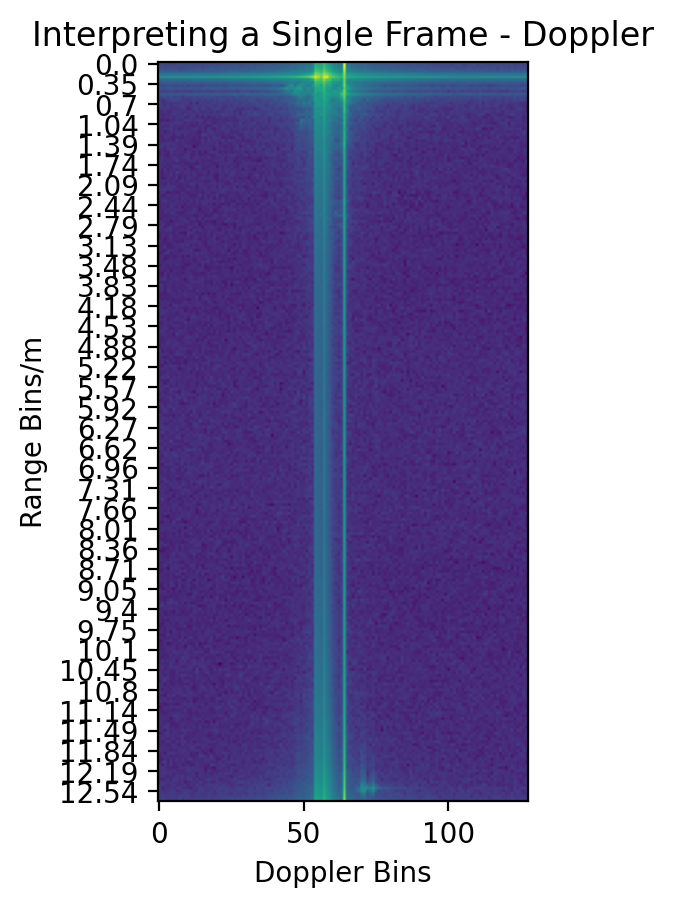

In [31]:
range_doppler = np.fft.fft(range_plot, axis=0)
range_doppler = np.fft.fftshift(range_doppler, axes=0)

# Visualize Results
plt.imshow(np.log(np.abs(range_doppler).T).sum(1))
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins/m')
plt.yticks(np.arange(ADC_PARAMS['samples'])[::7],ranges[::7])
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

### 计算Azimuth-FFT

In [32]:
#将矩形图像转为环形
def fanScan(im,r0=0,angle=180,k=7,top=True):
    """将矩形图像转为环形
    im          - 输入二维图像
    angle       - 环形夹角度数
    r0          - 环形内圆半径，r0=0输出扇形
    k           - 临近点插值密度（如果图像上出现白噪点，可适当增加k值）
    top         - 环心在上部
    """
    h, w = im.shape # 输入图像的高度、宽度和通道数

    if r0 > 0: # 输出环形的话，图像上部增加背景
        bg = np.zeros((r0, w))
        im = np.append(bg, im, axis=0) if top else np.append(im, bg, axis=0)

    h, w = im.shape # 加上背景后图像的高度、宽度
    r = 2*h-1  # 输出图像高度和宽度
    im_fan = np.zeros((r, r)) # 生成输出图像的numpy数组

    idx = np.arange(h) if top else np.arange(h)[::-1]
    alpha = np.radians(np.linspace(-angle/2, angle/2, k*w)) # 生成扇形角度序列
    for i in range(k*w): # 遍历输入图像的每一列
        rows = np.int32(np.ceil(np.cos(alpha[i])*idx)) + r//2
        cols = np.int32(np.ceil(np.sin(alpha[i])*idx)) + r//2
        im_fan[(rows, cols)] = im[:,i//k]

    if 360 > angle >= 180: # 裁切输出图像上部的空白区域
        im_fan = im_fan[int(h*(1-np.sin(np.radians((angle/2-90))))):]

    if not top:
        im_fan = im_fan[::-1]
    return im_fan

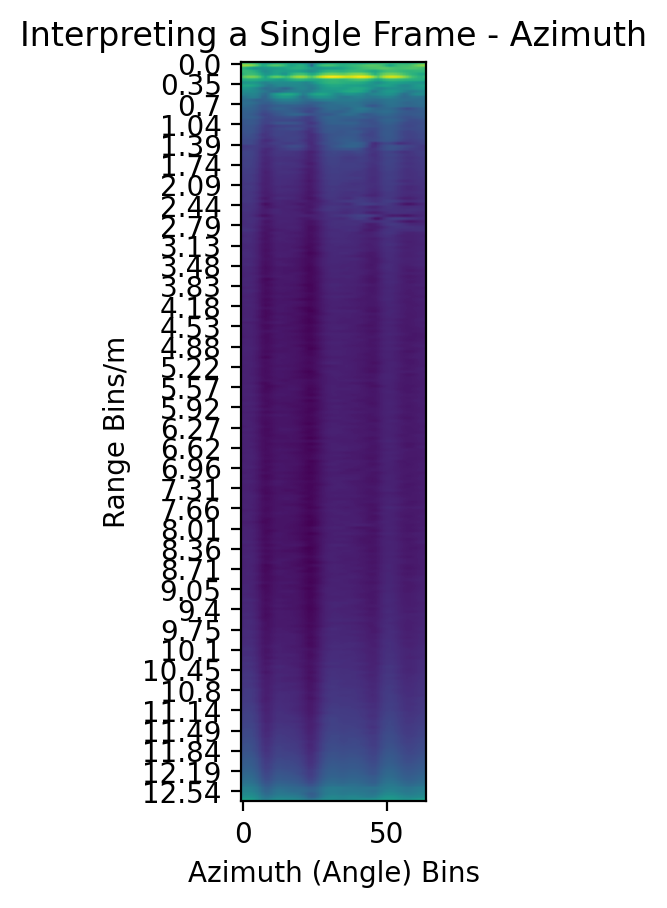

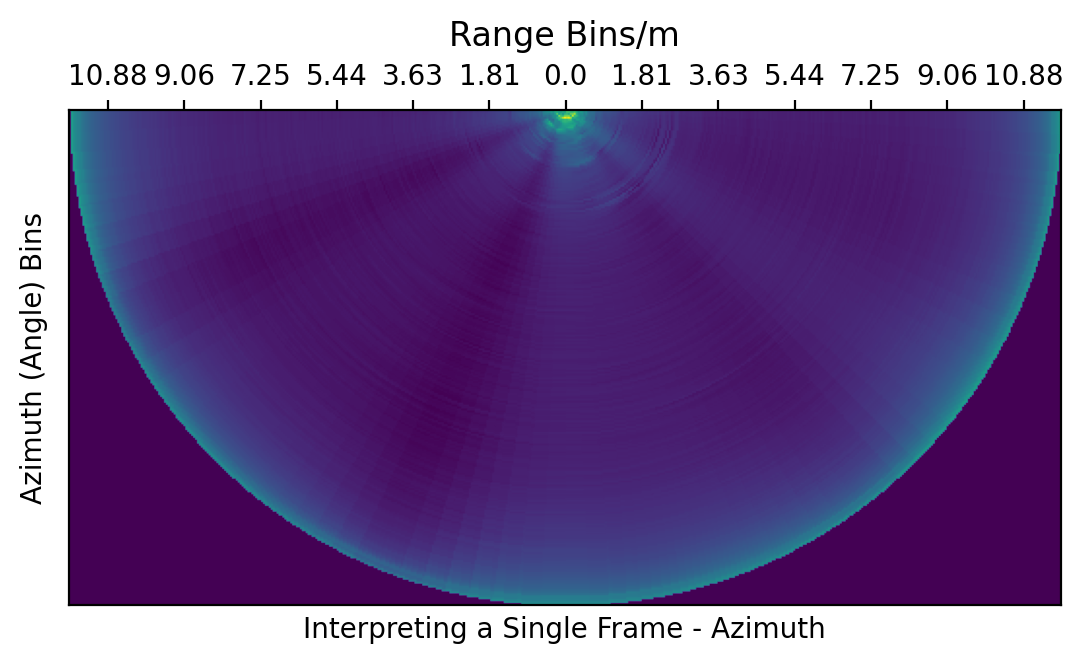

In [34]:
num_angle_bins = 64
padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0))
range_azimuth = np.pad(range_doppler, padding, mode='constant')
range_azimuth = np.fft.fft(range_azimuth, axis=1)
range_azimuth = np.fft.fftshift(range_azimuth, axes=1)
range_azimuth = range_azimuth
# 绘制平面图
range_azimuth_img=np.log(np.abs(range_azimuth).sum(0).T)
range_azimuth_img=range_azimuth_img-np.min(range_azimuth_img)
range_azimuth_img=range_azimuth_img/np.max(range_azimuth_img)
plt.imshow(range_azimuth_img)
plt.xlabel('Azimuth (Angle) Bins')
plt.ylabel('Range Bins/m')
plt.yticks(np.arange(ADC_PARAMS['samples'])[::7],ranges[::7])
plt.title('Interpreting a Single Frame - Azimuth')
plt.show()

#绘制扇扫图
im_fan=fanScan(range_azimuth_img,r0=0,angle=180,k=50,top=True)
plt.imshow(im_fan)

#坐标标签上移
ax = plt.gca()
ax.xaxis.set_ticks_position('top')

#标注距离
lableNum=7 #单侧标签个数
range_xlable=np.arange(0,ranges[-1],ranges[-1]/lableNum)
range_xlable=np.round(np.concatenate((range_xlable[:0:-1], range_xlable)),2)
range_xticks_l=np.arange((ADC_PARAMS['samples']*2-1)/2,0,-(ADC_PARAMS['samples']*2-1)/(2*lableNum-1))
range_xticks_h=np.arange((ADC_PARAMS['samples']*2-1)/2,ADC_PARAMS['samples']*2-1,(ADC_PARAMS['samples']*2-1)/(2*lableNum-1))
range_xticks=np.concatenate((range_xticks_l[:0:-1], range_xticks_h))
plt.xticks(range_xticks,range_xlable)

plt.yticks([])  # 去掉y轴
plt.title('Range Bins/m')
plt.ylabel('Azimuth (Angle) Bins')
plt.xlabel('Interpreting a Single Frame - Azimuth')
plt.show()